# This is code to downscale rough-resolution temperature to high-resolution one

## This is test for Himalaya and Tibet region (to see how AI handle stiff terrain is intersting case study)


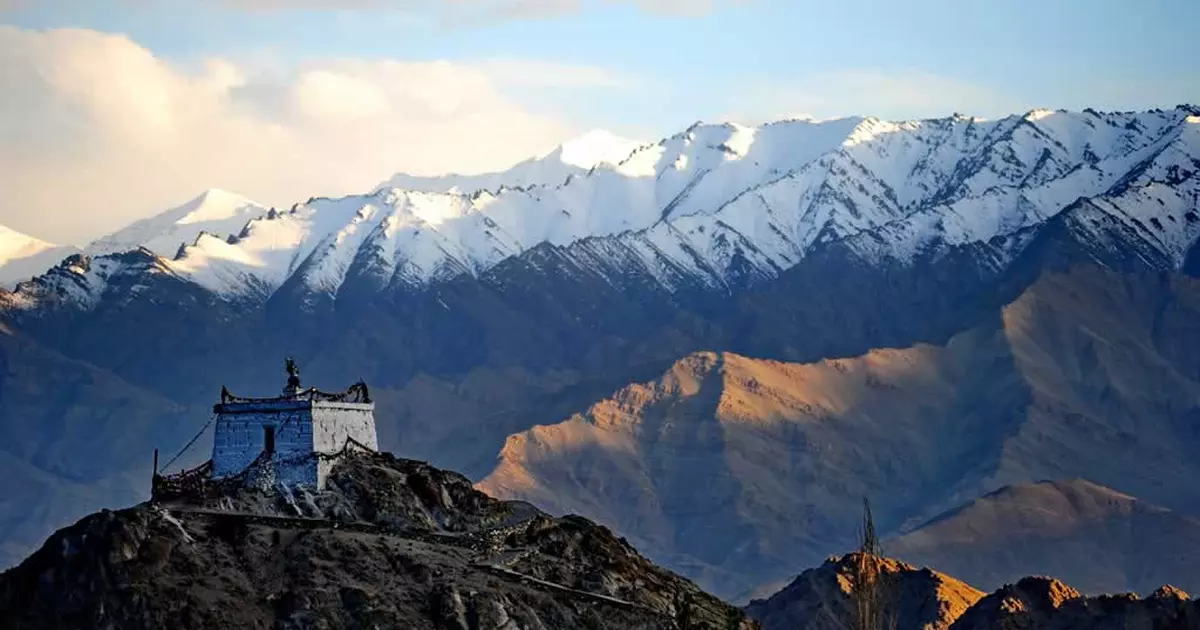

(https://vivitravels.com/en/guides/little-tibet-and-himalaya/)


## first let import libaries

If there is necessity to install any libraries, do it.

For example

conda install scipy 


In [1]:
from tensorflow import keras

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.17.1'

In [4]:
keras.__version__

'3.6.0'

In [5]:
'''
import numpy as np
import xarray as xr
import tensorflow as tf 
# all the layers used for U-net
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from tensorflow.keras.models import Model
import tensorflow.keras.utils as ku
from tensorflow.keras.optimizers import Adam
import sys
'''

'\nimport numpy as np\nimport xarray as xr\nimport tensorflow as tf \n# all the layers used for U-net\nfrom tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,\n                                     Conv2DTranspose, Input, MaxPool2D)\nfrom tensorflow.keras.models import Model\nimport tensorflow.keras.utils as ku\nfrom tensorflow.keras.optimizers import Adam\nimport sys\n'

In [6]:
import numpy as np
import xarray as xr
import tensorflow as tf 
# all the layers used for U-net
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                                     Conv2DTranspose, Input, MaxPool2D)
from keras.models import Model
import keras.utils as ku
from keras.optimizers import Adam
import sys

## Read input files (netcdf)
 there are three type of datasets (explained in step 1)

* first we normalize data (zero-mean, standard deviation)
* In each kind of data: 

X (predictors) having four dimensions (n_sample, y_axis, x_axis, n_variables)

Y (preditant) having three or four dimensions (n_sample, y_axis, x_axis, n_variables (optional) )
 

In [7]:
dtrain0 = xr.open_dataset('data/tb_train.nc')
dval0 = xr.open_dataset('data/tb_val.nc')
dtest0 = xr.open_dataset('data/tb_test.nc')

In [8]:
# normalize data 
def datnorm(d): 
    return (d - d.mean()) / d.std() 

In [9]:
# normalize data
dtrain, dval, dtest = datnorm(dtrain0), datnorm(dval0), datnorm(dtest0)

In [10]:
int_data = dtrain['lo'].values
X_train = np.expand_dims(int_data,3)
y_train = dtrain['hi'].values

In [11]:
X_val = np.expand_dims(dval['lo'].values,3)
y_val = dval['hi'].values

In [12]:
X_test = np.expand_dims(dtest['lo'].values,3)
y_test = dtest['hi'].values

In [13]:

print('Shape of X_train: ', X_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of X_validation: ', X_val.shape)
print('Shape of y_validation: ', y_val.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (255, 24, 32, 1)
Shape of y_train:  (255, 24, 32)
Shape of X_validation:  (66, 24, 32, 1)
Shape of y_validation:  (66, 24, 32)
Shape of X_test:  (44, 24, 32, 1)
Shape of y_test:  (44, 24, 32)


## Define encoder and decorder functions

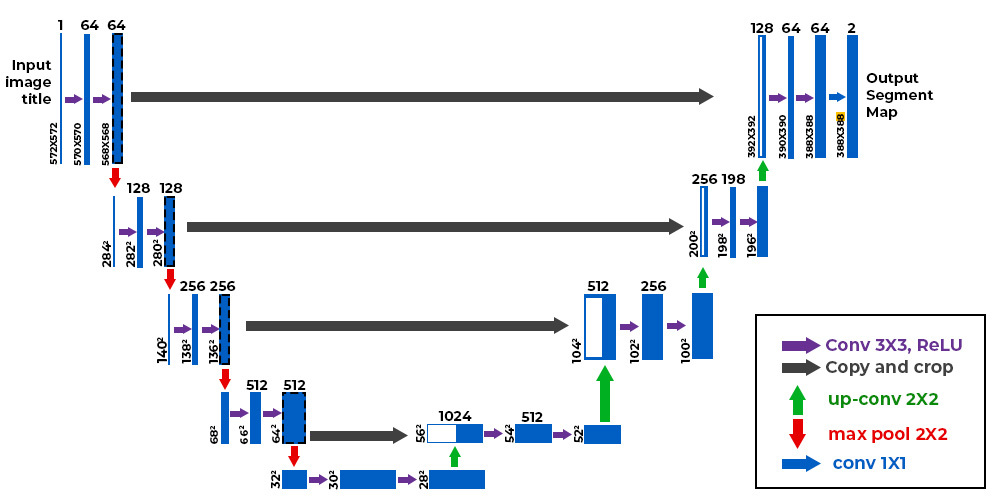


https://www.geeksforgeeks.org/u-net-architecture-explained/

With decoder UNet become different with normal CNN

### Enconder and decoder blocks combine series of convolution, activation, concaternate blocks

In [14]:
def conv_block(inputs, num_filters: int, kernel: tuple = (3,3), padding: str = "same",
               activation: str = "relu", kernel_init: str = "he_normal", l_batch_normalization: bool = True):
    """
    A convolutional layer with optional batch normalization
    :param inputs: the input data with dimensions nx, ny and nc
    :param num_filters: number of filters (output channel dimension)
    :param kernel: tuple indictating kernel size
    :param padding: technique for padding (e.g. "same" or "valid")
    :param activation: activation fuction for neurons (e.g. "relu")
    :param kernel_init: initialization technique (e.g. "he_normal" or "glorot_uniform")
    """
    x = Conv2D(num_filters, kernel, padding=padding, kernel_initializer=kernel_init)(inputs)
    if l_batch_normalization: x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

In [15]:
def conv_block_n(inputs, num_filters, n=2, kernel=(3,3), padding="same", activation="relu", 
                     kernel_init="he_normal", l_batch_normalization=True):
    """
    Sequential application of two convolutional layers (using conv_block).
    """
    
    x = conv_block(inputs, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    for i in np.arange(n-1):
        x = conv_block(x, num_filters, kernel, padding, activation,kernel_init, l_batch_normalization)
    
    return x

In [16]:
def encoder_block(inputs, num_filters, kernel_maxpool: tuple=(2,2), l_large: bool=True):
    """
    One complete encoder-block used in U-net
    """
    if l_large: x = conv_block_n(inputs, num_filters, n=2)
    else: x = conv_block(inputs, num_filters) 
    p = MaxPool2D(kernel_maxpool)(x)
    return x, p

In [17]:
def decoder_block(inputs, skip_features, num_filters, kernel: tuple=(3,3), strides_up: int=2, padding: str= "same", 
                  activation="relu", kernel_init="he_normal", l_batch_normalization: bool=True):
    """
    One complete decoder block used in U-net (reverting the encoder)
    """
    x = Conv2DTranspose(num_filters, (strides_up, strides_up), strides=strides_up, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block_n(x, num_filters, 2, kernel, padding, activation, kernel_init, l_batch_normalization)
    
    return x

### Define learning rate (need to learn more)

In [18]:
# define a earning-rate scheduler
def lr_scheduler(epoch, lr):
  if epoch < 5:
    return float(lr)
  elif epoch >= 5 and epoch < 30:
    return float(lr * tf.math.exp(-0.1))
  elif epoch >= 30:
    return float(lr)

In [19]:
#plt.plot([ lr_scheduler(e,5*10**(-4) ) for e in range(150)])

## BUILDING U-NET HERE

In [20]:
batch_size = 32
epochs = 150
channels_start=56 
shape_in = X_train.shape[1:]

In [21]:
# parameters 
callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# build model    
inputs = Input(shape_in)

""" encoder """
s1, e1 = encoder_block(inputs, channels_start, l_large=True)
s2, e2 = encoder_block(e1, channels_start*2, l_large=False)
s3, e3 = encoder_block(e2, channels_start*4, l_large=False)

""" bridge encoder <-> decoder """
b1 = conv_block(e3, channels_start*8)

""" decoder """
d1 = decoder_block(b1, s3, channels_start*4)
d2 = decoder_block(d1, s2, channels_start*2)
d3 = decoder_block(d2, s1, channels_start)

output_temp = Conv2D(1, (1,1), kernel_initializer="he_normal", name="output_temp")(d3)
unet_model= Model(inputs, output_temp, name="t2m_downscaling_unet")
#ku.plot_model(unet_model, show_shapes=True)
unet_model.compile(optimizer=Adam(learning_rate=5*10**(-4)), loss="mae")

## RUN U-NET HERE

It will take a while to train model

In [22]:

if 1: 
    history = unet_model.fit(x=X_train, 
                             y=y_train, 
                             batch_size=batch_size,
                             epochs=epochs, 
                             callbacks=[callback],
                             validation_data=(X_val, y_val ),
                             verbose = 1 # dont show ====== if want to show =1
                             )
    # save model to ecmwf
    unet_model.save('tb_small_1.keras')
    
    print('Finished run')

Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.5722 - val_loss: 0.5082 - learning_rate: 5.0000e-04
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.2675 - val_loss: 0.5576 - learning_rate: 5.0000e-04
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1925 - val_loss: 0.4184 - learning_rate: 5.0000e-04
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.1848 - val_loss: 0.4704 - learning_rate: 5.0000e-04
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.1588 - val_loss: 0.3930 - learning_rate: 5.0000e-04
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 0.1331 - val_loss: 0.2578 - learning_rate: 4.5242e-04
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - loss: 0.1356 - val_loss: 0.3063 - learning_rate: 4.0937e-04
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.1141 - val_loss: 0.2271 - learning_rate: 3.7041e-04
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.1057 - val_loss: 0.2072 - learning_

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=tb_small_1.

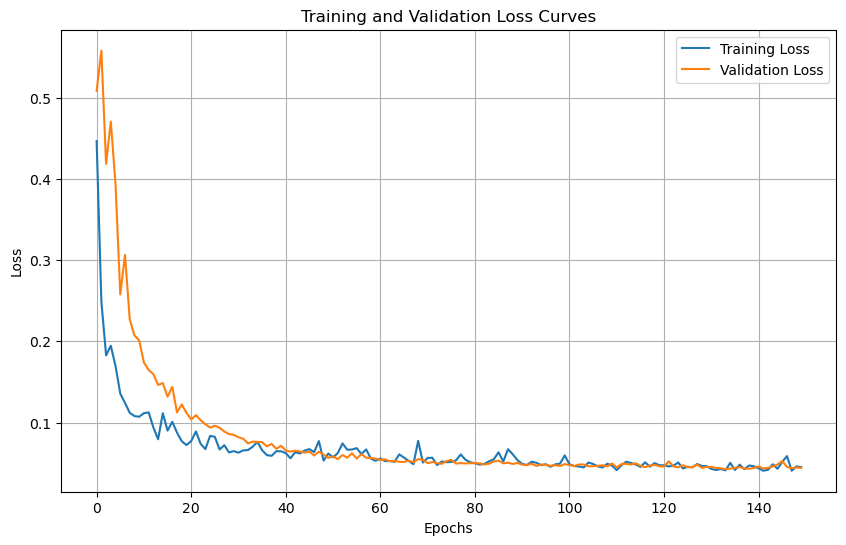

In [23]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
unet_model.save('tb_small_1.keras')

## Predict and verification

In [31]:
unet_model.save('tb_small_1.keras')

In [30]:
unet_model.summary()

Model: "t2m_downscaling_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 24, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 32,    │        560 │ input_layer_1[0]… │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 32,    │        224 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 24, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 24, 32,    │     28,280 │ activation_11[0]… │
│                     │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 32,    │        224 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 24, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 16,    │          0 │ activation_12[0]… │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 12, 16,    │     56,560 │ max_pooling2d_3[… │
│                     │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 16,    │        448 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 12, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 112)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 6, 8, 112) │          0 │ activation_13[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 6, 8, 224) │    226,016 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 8, 224) │        896 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 6, 8, 224) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 3, 4, 224) │          0 │ activation_14[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 3, 4, 448) │    903,616 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 10,577,117 (40.35 MB)

 Trainable params: 3,524,585 (13.45 MB)

 Non-trainable params: 3,360 (13.12 KB)

 Optimizer params: 7,049,172 (26.89 MB)